## In this Notebook
-Kaggle data of apps of Google Play Store is used, https://www.kaggle.com/lava18/google-play-store-apps

1, Creation of context

2, Preparation of data (get it into parquet)

3, MLlib based analysis

4, Visualization of results

In [1]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

# Initialize the spark environment (takes ~ 1min)

In [2]:
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

In [3]:
sqlc

## Connect to S3
There are a few ways to connect to S3, we are going to use boto
* boto3 - https://boto3.amazonaws.com/v1/documentation/api/latest/index.html

### Read into spark dataframe from csv in s3

In [4]:
role = get_execution_role()
bucket='odl-spark19spds6003-001'
data_key = 'sl4bz/house_price_nonDup.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
ppdf=pd.read_csv(data_location)

In [5]:
ppdf

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503
5,1230000.0,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,47.6561,-122.005,4760,101930
6,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,47.3097,-122.327,2238,6819
7,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,47.4095,-122.315,1650,9711
8,229500.0,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,47.5123,-122.337,1780,8113
9,323000.0,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,47.3684,-122.031,2390,7570


In [6]:
ppdf=ppdf.dropna()

In [7]:
df = sqlc.createDataFrame(ppdf)

In [8]:
df

DataFrame[price: double, bedrooms: bigint, bathrooms: double, sqft_living: bigint, sqft_lot: bigint, floors: double, waterfront: bigint, view: bigint, condition: bigint, grade: bigint, sqft_above: bigint, sqft_basement: bigint, yr_built: bigint, yr_renovated: bigint, lat: double, long: double, sqft_living15: bigint, sqft_lot15: bigint]

In [9]:
type(df)

pyspark.sql.dataframe.DataFrame

### Write parquet to s3

In [12]:
parquetPath = '/home/ec2-user/SageMaker/sl4bz/tmp-pqt1'
df.write.parquet(parquetPath)

In [13]:
# prep list of files to transfer
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

s3 = boto3.resource('s3')
for f in files:
    #print('copying {} to {}'.format(parquetPath+'/'+f,"sample_data/"+f))
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "sl4bz/pqt/"+f)


### Write to spark dataframe from parquet

In [14]:
df = sqlc.read.parquet(parquetPath)

In [15]:
df

DataFrame[price: double, bedrooms: bigint, bathrooms: double, sqft_living: bigint, sqft_lot: bigint, floors: double, waterfront: bigint, view: bigint, condition: bigint, grade: bigint, sqft_above: bigint, sqft_basement: bigint, yr_built: bigint, yr_renovated: bigint, lat: double, long: double, sqft_living15: bigint, sqft_lot15: bigint]

## MLlib Basics
* exploratory tools


In [16]:
display(df)

DataFrame[price: double, bedrooms: bigint, bathrooms: double, sqft_living: bigint, sqft_lot: bigint, floors: double, waterfront: bigint, view: bigint, condition: bigint, grade: bigint, sqft_above: bigint, sqft_basement: bigint, yr_built: bigint, yr_renovated: bigint, lat: double, long: double, sqft_living15: bigint, sqft_lot15: bigint]

In [17]:
df.printSchema()

root
 |-- price: double (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: long (nullable = true)
 |-- sqft_lot: long (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: long (nullable = true)
 |-- view: long (nullable = true)
 |-- condition: long (nullable = true)
 |-- grade: long (nullable = true)
 |-- sqft_above: long (nullable = true)
 |-- sqft_basement: long (nullable = true)
 |-- yr_built: long (nullable = true)
 |-- yr_renovated: long (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: long (nullable = true)
 |-- sqft_lot15: long (nullable = true)



In [18]:
df.take(5)

[Row(price=221900.0, bedrooms=3, bathrooms=1.0, sqft_living=1180, sqft_lot=5650, floors=1.0, waterfront=0, view=0, condition=3, grade=7, sqft_above=1180, sqft_basement=0, yr_built=1955, yr_renovated=0, lat=47.5112, long=-122.257, sqft_living15=1340, sqft_lot15=5650),
 Row(price=538000.0, bedrooms=3, bathrooms=2.25, sqft_living=2570, sqft_lot=7242, floors=2.0, waterfront=0, view=0, condition=3, grade=7, sqft_above=2170, sqft_basement=400, yr_built=1951, yr_renovated=1991, lat=47.721000000000004, long=-122.319, sqft_living15=1690, sqft_lot15=7639),
 Row(price=180000.0, bedrooms=2, bathrooms=1.0, sqft_living=770, sqft_lot=10000, floors=1.0, waterfront=0, view=0, condition=3, grade=6, sqft_above=770, sqft_basement=0, yr_built=1933, yr_renovated=0, lat=47.7379, long=-122.23299999999999, sqft_living15=2720, sqft_lot15=8062),
 Row(price=604000.0, bedrooms=4, bathrooms=3.0, sqft_living=1960, sqft_lot=5000, floors=1.0, waterfront=0, view=0, condition=5, grade=7, sqft_above=1050, sqft_basement=9

In [19]:
print("Pearson's r(bathrooms,price) = {}".format(df.corr("bathrooms", "price")))
print("Pearson's r(sqft_living,price) = {}".format(df.corr("sqft_living", "price")))
print("Pearson's r(yr_built,price) = {}".format(df.corr("yr_built", "price")))
print("Pearson's r(sqft_living,sqft_above) = {}".format(df.corr("sqft_living","sqft_above")))
print("Pearson's r(lat,long) = {}".format(df.corr("lat","long")))

Pearson's r(bathrooms,price) = 0.5251426177802101
Pearson's r(sqft_living,price) = 0.7020438258604101
Pearson's r(yr_built,price) = 0.054032132322813155
Pearson's r(sqft_living,sqft_above) = 0.876592715793639
Pearson's r(lat,long) = -0.1355573500012344


It's obvious that squarefoot living and squarefoot above are correlated   
In this case we are going to compute some new features--slpsa,lprice.

In [20]:
from pyspark.sql.functions import log
from pyspark.sql.functions import col
df = df.withColumn('slpsa', df.sqft_living / df.sqft_above)
df = df.withColumn('lprice', log(df.price))
df = df.drop('price')
df.printSchema()

root
 |-- bedrooms: long (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: long (nullable = true)
 |-- sqft_lot: long (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: long (nullable = true)
 |-- view: long (nullable = true)
 |-- condition: long (nullable = true)
 |-- grade: long (nullable = true)
 |-- sqft_above: long (nullable = true)
 |-- sqft_basement: long (nullable = true)
 |-- yr_built: long (nullable = true)
 |-- yr_renovated: long (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: long (nullable = true)
 |-- sqft_lot15: long (nullable = true)
 |-- slpsa: double (nullable = true)
 |-- lprice: double (nullable = true)



In [21]:
print("Pearson's r(sqft_living,sqft_above) = {}".format(df.corr("sqft_living", "sqft_above")))
print("Pearson's r(sqft_living,slpsa) = {}".format(df.corr("sqft_living", "slpsa")))
print()
print("Pearson's r(sqft_living,sqft_above) = {}".format(df.corr("sqft_living", "sqft_above")))
print("Pearson's r(sqft_living,slpsa) = {}".format(df.corr("sqft_living", "slpsa")))
print()

Pearson's r(sqft_living,sqft_above) = 0.876592715793639
Pearson's r(sqft_living,slpsa) = 0.19590603309723295

Pearson's r(sqft_living,sqft_above) = 0.876592715793639
Pearson's r(sqft_living,slpsa) = 0.19590603309723295



### Select two features for analysis
* sqft_living = feature
* price = label

In [22]:
df = df.select("sqft_living","lprice")

## Finally, ML time
1. split data into train/test
2. **SPARK SPECIAL SAUCE** -  pysparki.ml.linalg - vectorization
3. Train --> Predict --> Evaluate

### Make Training and Test sets

In [23]:
# create train/test sets
seed = 42
(testDF, trainingDF) = df.randomSplit((0.30, 0.70), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 15070, test set N = 6538


# VECTORIZATION - spark special sauce

In [24]:
from pyspark.ml.linalg import Vectors, VectorUDT # nb: bad form, done for pedagogy

In [25]:
# make a user defined function (udf)
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())

# vectorize the data frames
trainingDF = trainingDF.selectExpr("lprice", "oneElementVec(sqft_living) as sqft_living")
testDF = testDF.selectExpr("lprice", "oneElementVec(sqft_living) as sqft_living")

print(testDF.orderBy(testDF.lprice.desc()).limit(5))

DataFrame[lprice: double, sqft_living: vector]


In [26]:
# rename to make ML engine happy, for linear regression they have to be "label","features",dense vectors
trainingDF = trainingDF.withColumnRenamed("lprice", "label").withColumnRenamed("sqft_living", "features")
testDF = testDF.withColumnRenamed("lprice", "label").withColumnRenamed("sqft_living", "features")

## ML
1. Train
2. Predict
3. Evaluate

In [27]:
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

lr = LinearRegression()
lrModel = lr.fit(trainingDF)

In [28]:
type(lrModel)

pyspark.ml.regression.LinearRegressionModel

In [29]:
predictionsAndLabelsDF = lrModel.transform(testDF)

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(label=15.483217378522351, features=DenseVector([7390.0]), prediction=15.160691991443286), Row(label=15.35666962964508, features=DenseVector([9640.0]), prediction=16.0568277966743), Row(label=15.252973205658565, features=DenseVector([7440.0]), prediction=15.18060612044842), Row(label=15.126542434583618, features=DenseVector([5550.0]), prediction=14.427852044054372), Row(label=15.110237725558674, features=DenseVector([5020.0]), prediction=14.216762276599956)]


## Model Evaluation

In [30]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator()
print(eval.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation - one of:
                       rmse - root mean squared error (default)
                       mse - mean squared error
                       r2 - r^2 metric
                       mae - mean absolute error. (default: rmse)
predictionCol: prediction column name. (default: prediction)


In [31]:
type(eval)

pyspark.ml.evaluation.RegressionEvaluator

In [32]:
eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)

0.3811293236530367

In [33]:
eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)

0.4737400871706826

# Visualization

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
import pandas as pd
import requests

In [35]:
x=df.toPandas()['lprice']

Text(0.5,1,'Distribution of Rating')

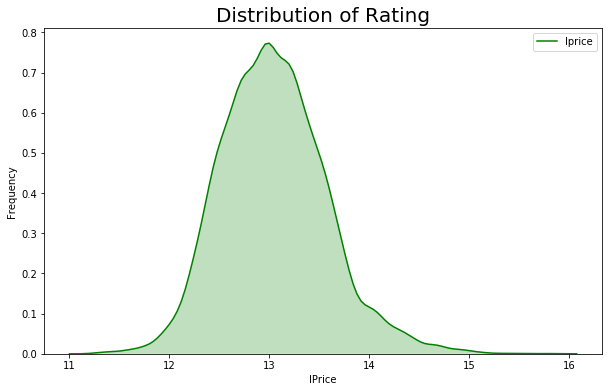

In [36]:
plt.figure(figsize=(10,6))
rating = sns.kdeplot(x, color="Green", shade = True)
rating.set_xlabel("lPrice")
rating.set_ylabel("Frequency")
plt.title('Distribution of Rating',size = 20)

In [41]:
a=df.toPandas()['lprice']
b=df.toPandas()['sqft_living']
c=pd.DataFrame(a,b)
c=c.reset_index()
c.columns=['lprice','sqft_living']

In [42]:
c.head(5)

,lprice,sqft_living
0,1180,13.624350
1,2570,12.496295
2,770,12.971308
3,1960,13.592367
4,1680,13.142166


Text(0.5,1,'Squre feet Living VS Price.log')

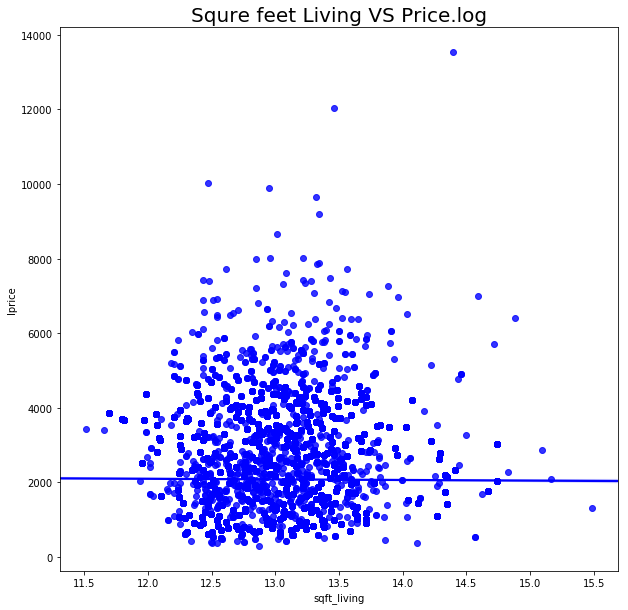

In [44]:
#Plot sqft_living VS lprice
plt.figure(figsize = (10,10))
sns.regplot(x="sqft_living", y="lprice", color = 'Blue',data=c);
plt.title('Squre feet Living VS Price.log',size = 20)
#The applications with more reviews get higher ratings.

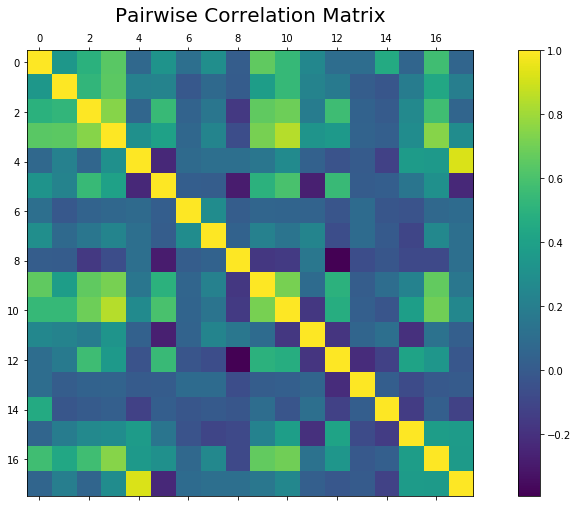

In [49]:
#Feature correlation matrix
df = sqlc.createDataFrame(ppdf)
df1=df.toPandas()
fig = plt.figure(figsize = (16,8))
corr = df1.corr(method = 'spearman', min_periods = 10)
plot = plt.matshow(corr, fignum = 1)
plt.title('Pairwise Correlation Matrix',size=20)
fig.colorbar(plot)